<a href="https://colab.research.google.com/github/rdkdaniel/Quantum-Computers-and-ML-DL/blob/main/Quantum_Computers_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A General Review**

**Introduction**

Interesting Reads and Resources:


*   https://www.nature.com/articles/s41467-021-22539-9
*   https://ai.googleblog.com/2021/06/quantum-machine-learning-and-power-of.html
*   https://blog.paperspace.com/beginners-guide-to-quantum-machine-learning/
*   https://research.ibm.com/topics/quantum-machine-learning
*   https://www.nature.com/articles/s41567-021-01287-z



In [ ]:
#Good paper on power of data in Quantum ML: https://www.nature.com/articles/s41467-021-22539-9

In [ ]:
#Quantum advantage over a classical computer is often framed in terms of computational complexity classes. 
#Examples such as factoring large numbers and simulating quantum systems are classified as bounded quantum polynomial time (BQP) problems.
#Which are those thought to be handled more easily by quantum computers than by classical systems. 
#Problems easily solved on classical computers are called bounded probabilistic polynomial (BPP) problems

In [ ]:
#Google Research show:
#Learning algorithms equipped with data from a quantum process, such as a natural process like fusion or chemical reactions, form a new class of problems (which they call BPP/Samp).
#That efficiently perform some tasks that traditional algorithms without data cannot, and is a subclass of the problems efficiently solvable with polynomial sized advice (P/poly). 
#This demonstrates that for some machine learning tasks, understanding the quantum advantage requires examination of available data as well.

In [ ]:
#Checkout the image showing the intersection of BQP, BPP, BPP/Samp and P/Poly

# **Quantum Data**

In the section below, I follow the work of Huang et al. Their work shows how different datasets affect performance comparisons.

Furthermore, the authors try to understand how and when classical machine learning models can learn as well as quantum models.

To achieve these objectives, the project showcases an empirical performance separation between classical and quantum machine learning model via a carefully crafted dataset.

As such, the implementation below:


1.   Prepares a reduced dimension Fashion-MNIST dataset.
2.   Use quantum circuits to re-label the dataset and compute Projected Quantum Kernel features (PQK).
3.   Train a classical neural network on the re-labeled dataset and compare the performance with a model that has access to the PQK features.




## **Dependencies & Setup**

In [1]:
pip install tensorflow==2.7.0 tensorflow-quantum==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 10.5 MB 4.4 MB/s 
     |████████████████████████████████| 463 kB 75.3 MB/s 
     |████████████████████████████████| 1.3 MB 74.4 MB/s 
     |████████████████████████████████| 100 kB 10.5 MB/s 
     |████████████████████████████████| 90 kB 11.7 MB/s 
     |████████████████████████████████| 6.1 MB 32.1 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 576 kB 70.0 MB/s 
     |████████████████████████████████| 1.6 MB 62.4 MB/s 
     |████████████████████████████████| 1.0 MB 52.6 MB/s 
     |████████████████████████████████| 115 kB 71.7 MB/s 
     |████████████████████████████████| 641 kB 75.1 MB/s 
     |████████████████████████████████| 541 kB 26.9 MB/s 
     |████████████████████████████████| 541 kB 57.9 MB/s 
     |███████████████████████████

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [3]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

## **Data Prep**

Preparing the fashion-MNIST dataset for running on a quantum computer.

### **Downloading the fashion-MNIST dataset**

Getting the traditional fashion-mnist dataset. 

This is done using the tf.keras.datasets module

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


4431872/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Filtering the dataset to keep just the T-shirts/tops and dresses.

At the same time convert the label, y, to boolean: True for 0 and False for 3.

In [5]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [6]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


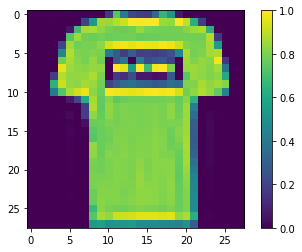

In [7]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()


### **Downscale the images**

Just like the MNIST example, you will need to downscale these images in order to be within the boundaries of current quantum computers. 

This time however you will use a PCA transformation to reduce the dimensions instead of a tf.image.resize operation.

In [8]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])


In [9]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))


New datapoint dimension: 10


The last step is to reduce the size of the dataset to just 1000 training datapoints and 200 testing datapoints.

In [10]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]


In [11]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))


New number of training examples: 1000
New number of test examples: 200


## **Relabeling and computing PQK features**

You will now prepare a "stilted" quantum dataset by incorporating quantum components and re-labeling the truncated fashion-MNIST dataset you've created above. 

In order to get the most seperation between quantum and classical methods, you will first prepare the PQK features and then relabel outputs based on their values. 

### **Quantum encoding and PQK features**

You will create a new set of features, based on x_train, y_train, x_test and y_test that is defined to be the 1-RDM on all qubits of: 

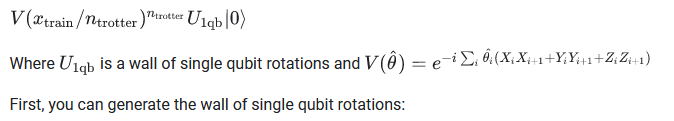


In [12]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

You can quickly verify this works by looking at the circuit:

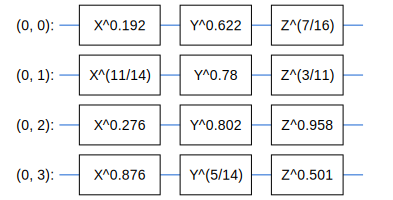

In [13]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

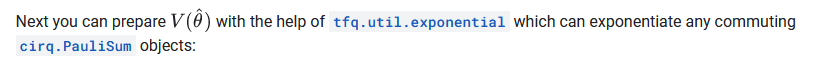

In [14]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

This circuit might be a little bit harder to verify by looking at, but you can still examine a two qubit case to see what is happening:

Symbols found in circuit:[ref_0]


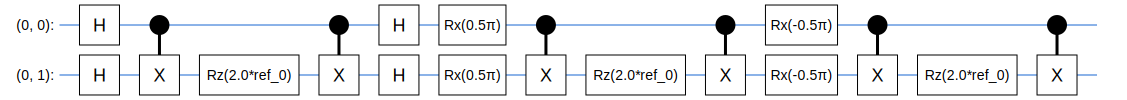

In [15]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

Now you have all the building blocks you need to put your full encoding circuits together:

In [16]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

Choose some qubits and prepare the data encoding circuits:

In [17]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

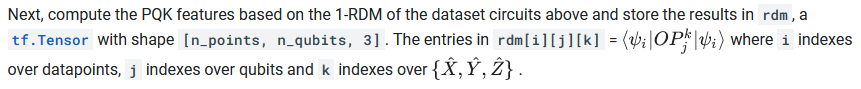

In [18]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [19]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)


New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


### **Re-labeling based on PQK features**

Now that you have these quantum generated features in x_train_pqk and x_test_pqk, it is time to re-label the dataset. To achieve maximum seperation between quantum and classical performance you can re-label the dataset based on the spectrum information found in x_train_pqk and x_test_pqk.

In [20]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [21]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[ 0.02095691  0.01059749  0.02166335 ... -0.04759856 -0.0033847
   0.02826779]
 [ 0.02293035  0.04663553  0.00791171 ... -0.00487034 -0.72146726
   0.02858998]
 [ 0.01778553 -0.00300761 -0.0255226  ... -0.07188051 -0.00304971
   0.02690102]
 ...
 [-0.06057926  0.01324827  0.02695332 ...  0.01029877 -0.06313895
   0.03853427]
 [-0.06333077 -0.00304116  0.00977424 ...  0.03602503 -0.01644086
   0.03674837]
 [-0.05860284  0.00584426  0.00264821 ...  0.00413976 -0.03942705
   0.03299443]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 3.83568294e-02  2.83472948e-02 -1.16978735e-02 ...  2.09244993e-02
   2.88614538e-03  3.20697054e-02]
 [-4.01817113e-02  8.88094865e-03 -1.38825774e-02 ...  4.59459471e-03
  -7.09800303e-01  2.88196597e-02]
 [-1.66718997e-02  1.35037443e-02 -3.66385952e-02 ... -1.21934175e-01
   2.84691574e-03  2.19540894e-02]
 ...
 [-3.01564876e-02 -1.67163145e-02 -1.60339233e-02 ...  6

Now you have everything you need to re-label the dataset! Now you can consult with the flowchart to better understand how to maximize performance seperation when re-labeling the dataset:

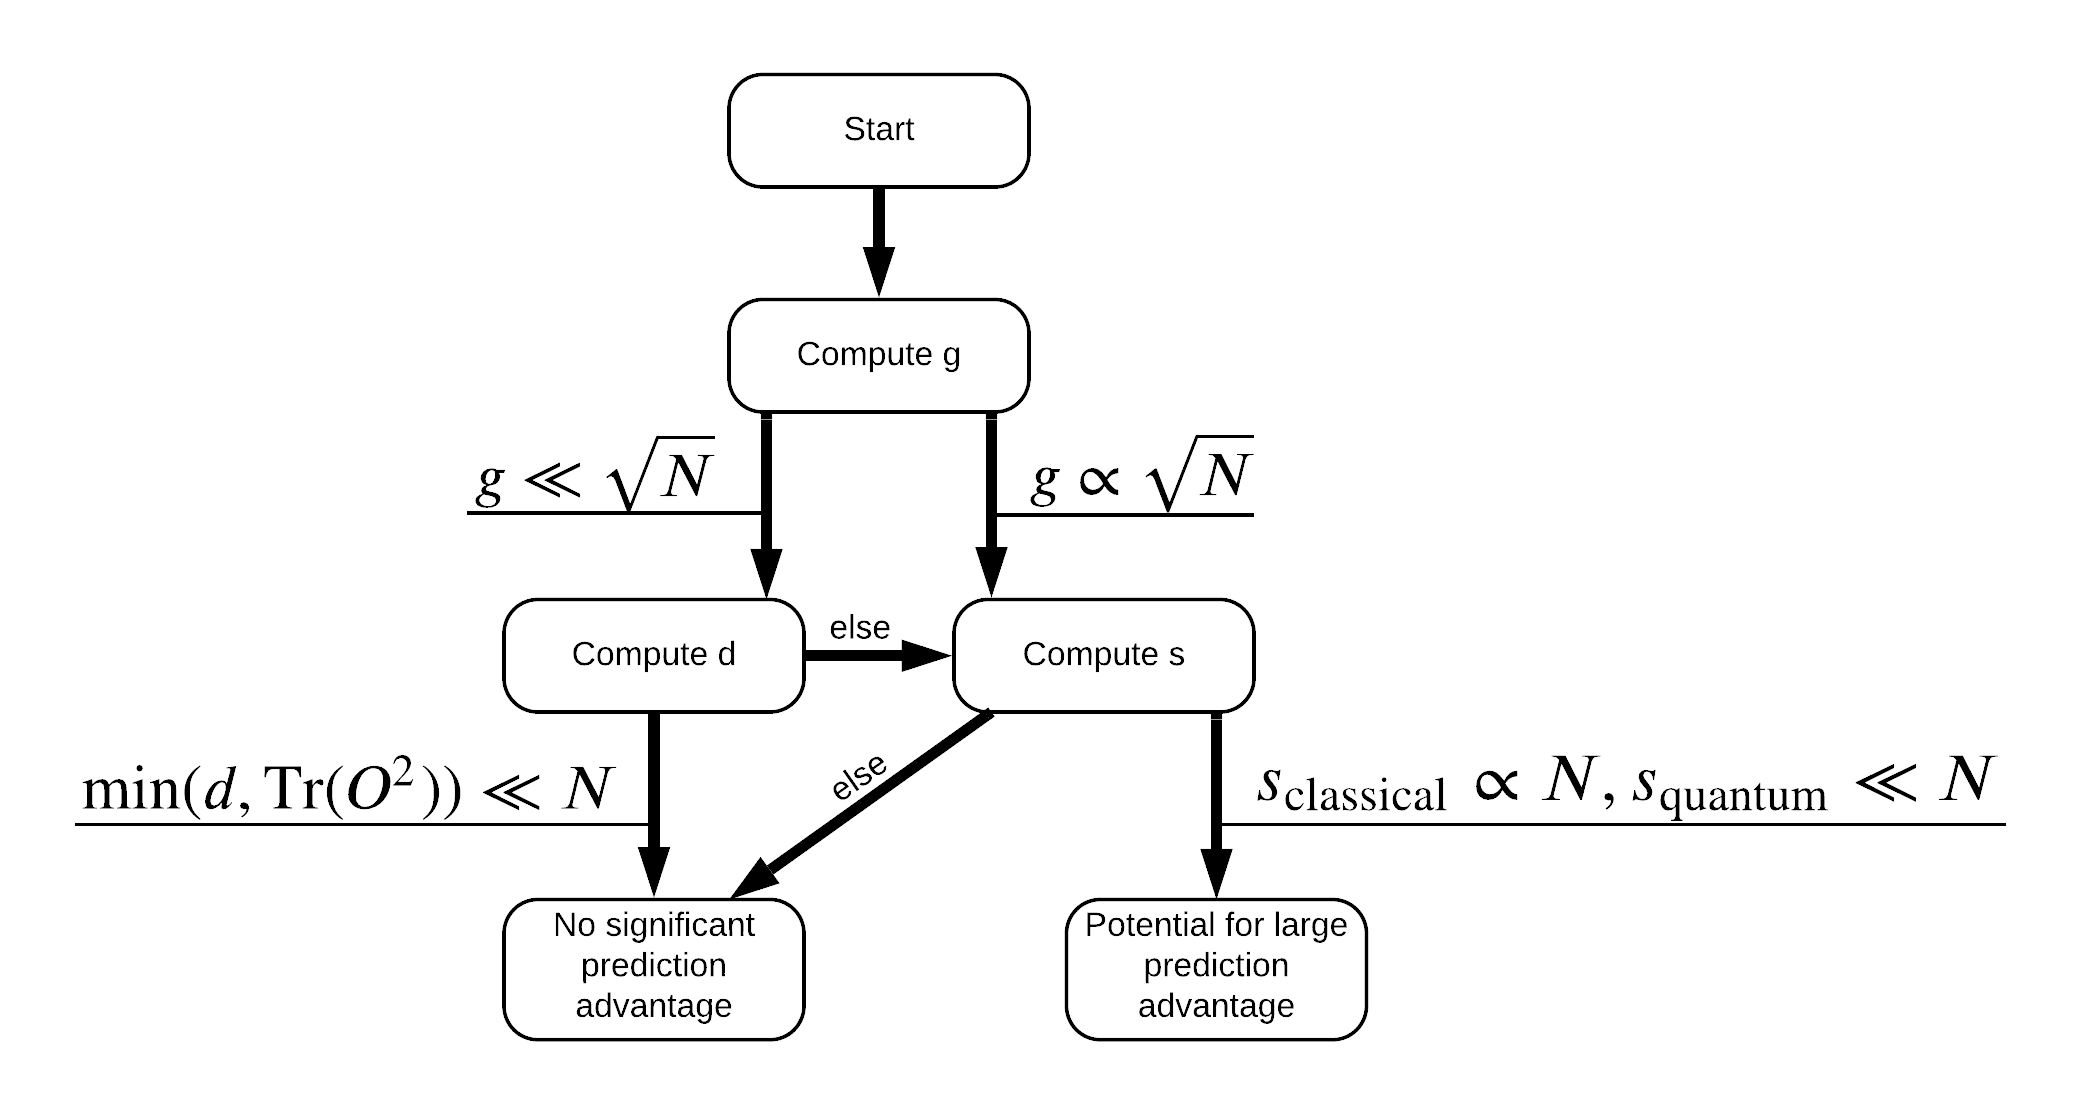

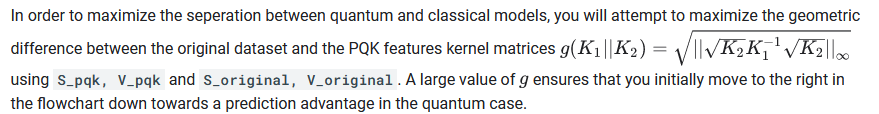

In [22]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [23]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

## **Comparing models**

Now that you have prepared your dataset it is time to compare model performance. You will create two small feedforward neural networks and compare performance when they are given access to the PQK features found in x_train_pqk.

### **Create PQK enhanced model**

Using standard tf.keras library features you can now create and a train a model on the x_train_pqk and y_train_new datapoints:

In [24]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [25]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))


### **Create a classical model**

Similar to the code above you can now also create a classical model that doesn't have access to the PQK features in your stilted dataset. This model can be trained using x_train and y_label_new.

In [26]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [27]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))


### **Compare performance**

Now that you have trained the two models you can quickly plot the performance gaps in the validation data between the two. Typically both models will achieve > 0.9 accuaracy on the training data. However on the validation data it becomes clear that only the information found in the PQK features is enough to make the model generalize well to unseen instances.

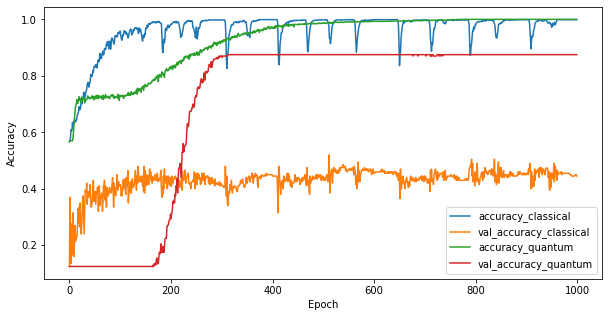

In [28]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()